In [1]:
import re

def comprehensive_preprocessing(text):
    # Menghapus URL
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)

    # Menghapus karakter khusus dan angka
    text = re.sub(r'\W|[\d_]', ' ', text)

    # Menghapus kata yang berulang
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)

    # Menghapus emoji atau simbol khusus
    emoji_pattern = re.compile(
        "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F700-\U0001F77F"  # alchemical symbols
        u"\U0001F780-\U0001F7FF"  # Geometric Shapes Extended
        u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA00-\U0001FA6F"  # Chess Symbols
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U00002702-\U000027B0"  # Dingbats
        u"\U000024C2-\U0001F251"
        "]+"
    )
    text = emoji_pattern.sub(r'', text)

    # Menghapus tanda baca
    text = re.sub(r'[^\w\s#]', ' ', text)

    # Menghapus kata-kata singkat
    text = ' '.join([word for word in text.split() if len(word) > 2])

    # Menghapus mention
    text = re.sub(r'@\w+', '', text)

    # Mengonversi teks ke huruf kecil
    text = text.lower()

    # Menghapus spasi berlebih
    text = ' '.join(text.split())

    return text

In [2]:
import numpy as np
import joblib

# jurnal_id = 1000
jurnal_id = 10004

# Load model KMeans
filename_kmeans = f"src/{jurnal_id}_kmeans.pkl"
kmeans_model = joblib.load(filename_kmeans)
print("Model KMeans telah dimuat.")

# Load threshold
threshold = np.load(f"src/{jurnal_id}_threshold.npy")
print("Threshold telah dimuat:", threshold)

# Load data sebaran PCA
X_pca = np.load(f"src/{jurnal_id}_pca_data.npy")
print("Data sebaran PCA telah dimuat.")

# Load data sebaran BERT
X_bert = np.load(f"src/{jurnal_id}_bert_data.npy")
print("Data sebaran PCA telah dimuat.")


Model KMeans telah dimuat.
Threshold telah dimuat: 168.40497970581055
Data sebaran PCA telah dimuat.
Data sebaran PCA telah dimuat.


In [7]:
X_bert

array([[-0.00378281, -0.25272194, -0.05744395, ...,  0.17308089,
        -0.15780789,  0.33116087],
       [ 0.01210911,  0.0152438 ,  0.03549722, ..., -0.1393806 ,
         0.10625906, -0.15861434],
       [-0.00996359,  0.04180917,  0.11505423, ..., -0.05876517,
         0.167252  , -0.12059599],
       ...,
       [ 0.16396736, -0.56746924,  0.30853736, ...,  0.31847626,
         0.19484864, -0.00958782],
       [ 0.07801434, -0.05013546,  0.04583542, ..., -0.08867656,
         0.16837628, -0.14756677],
       [-0.08530182, -0.12332331,  0.18065846, ...,  0.17923085,
         0.56210744, -0.40558186]], dtype=float32)

In [10]:
X_pca

array([[-0.00378281, -0.25272194, -0.05744395, ...,  0.17308089,
        -0.15780789,  0.33116087],
       [ 0.01210911,  0.0152438 ,  0.03549722, ..., -0.1393806 ,
         0.10625906, -0.15861434],
       [-0.00996359,  0.04180917,  0.11505423, ..., -0.05876517,
         0.167252  , -0.12059599],
       ...,
       [ 0.16396736, -0.56746924,  0.30853736, ...,  0.31847626,
         0.19484864, -0.00958782],
       [ 0.07801434, -0.05013546,  0.04583542, ..., -0.08867656,
         0.16837628, -0.14756677],
       [-0.08530182, -0.12332331,  0.18065846, ...,  0.17923085,
         0.56210744, -0.40558186]], dtype=float32)

In [3]:
from sklearn.decomposition import PCA

def fit_new_data_to_pca(new_data, pca):
    # Transformasi data baru ke ruang PCA yang sama dengan data lama
    new_data_pca = pca.transform(new_data.reshape(1, -1))

    return new_data_pca

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np
import torch

def predict_scoop(title, abstract, tokenizer, model, kmeans_model, scoop_threshold, pca_data):
    # Preprocess title and abstract
    processed_text = comprehensive_preprocessing(title + abstract)

    # Tokenize new data
    encoded_dict = tokenizer.encode_plus(
        processed_text,
        add_special_tokens=True,
        max_length=128,
        pad_to_max_length=True,
        return_attention_mask=True,
        return_tensors='pt'
    )

    # Calculate embedding for new data
    input_ids = encoded_dict['input_ids'].to(device)
    attention_mask = encoded_dict['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids, attention_mask=attention_mask)
        last_hidden_states = outputs.last_hidden_state
        new_embedding = last_hidden_states.cpu().numpy().reshape(1, -1)

    # Perform PCA on new_embedding
    pca = PCA(n_components=pca_data.shape[1], random_state=0)
    pca.fit(X_bert)

    new_data_pca = fit_new_data_to_pca(new_embedding, pca)
    print("new data :", new_data_pca, "cluster center :", kmeans_model.cluster_centers_)

    # Calculate distance to centroid
    distance_to_centroid = np.sqrt(np.sum((new_data_pca - kmeans_model.cluster_centers_)**2, axis=1))
    print("Distance", distance_to_centroid)
    print("inscoop", distance_to_centroid <= scoop_threshold)

    # Determine if new data is in scoop or outscoop
    if distance_to_centroid <= scoop_threshold:
        prediction = "in scoop"
    else:
        prediction = "out scoop"

    return prediction, new_data_pca


In [5]:
# Personalisasi Partai Politik di Indonesia Era Reformasi Mayoritas partai politik di Indonesia pada era reformasi telah terjebak pada persoalan personalisasi politik. Individu elite partai menjadi image partai sekaligus orang yang sangat berpengaruh dalam pembuatan kebijakan partai dalam jangka waktu yang lama. Padahal, partai politik telah memiliki mekanisme suksesi, namun satu sosok elite tetap mampu mempersonalkan partainya. Penelitian ini melihat ada beberapa aspek yang menjadi penyebabnya, termasuk sejarah pendirian partai, kepemimpinan karismatik dan pendanaan partai. Di luar itu, presidensialisme, sistem kepartaian dan sistem pemilu menjadi faktor yang turut memfasilitasi munculnya personalisasi partai. Personalisasi partai ini harus dihindari karena dalam jangka panjang akan berdampak negatif tidak hanya kepada partai politik, tetapi juga pada upaya penegakan demokrasi di Indonesia.

In [9]:
import torch
from transformers import BertTokenizer, AutoModel
import joblib
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Load pre-trained IndoBERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
model = AutoModel.from_pretrained('bert-base-multilingual-cased')

device = 'cpu'

model.to(device)
model.eval()

# User input for title and abstract
# judul_baru = 'Personalisasi Partai Politik di Indonesia Era Reformasi Mayoritas partai politik di Indonesia'
# abstrak_baru = 'pada era reformasi telah terjebak pada persoalan personalisasi politik. Individu elite partai menjadi image partai sekaligus orang yang sangat berpengaruh dalam pembuatan kebijakan partai dalam jangka waktu yang lama. Padahal, partai politik telah memiliki mekanisme suksesi, namun satu sosok elite tetap mampu mempersonalkan partainya. Penelitian ini melihat ada beberapa aspek yang menjadi penyebabnya, termasuk sejarah pendirian partai, kepemimpinan karismatik dan pendanaan partai. Di luar itu, presidensialisme, sistem kepartaian dan sistem pemilu menjadi faktor yang turut memfasilitasi munculnya personalisasi partai. Personalisasi partai ini harus dihindari karena dalam jangka panjang akan berdampak negatif tidak hanya kepada partai politik, tetapi juga pada upaya penegakan demokrasi di Indonesia.'

judul_baru = 'Pemodelan Topik menggunakan pre-trained language model indoBERT dan variational autoencoders'
abstrak_baru = 'Jumlah informasi dan dokumen yang tersebar di internet saat ini sudah sangat besar dan menyebabkan pencarian informasi sesuai topik masih sulit dilakukan. Hal ini menjadi tantangan dalam pengelompokan dan pengelolaan informasi seperti data judul berita online. Oleh karena itu, solusi untuk permasalahan ini adalah dengan menggunakan Sistem Pemodelan Topik yang bertujuan untuk mengelompokkan informasi dan dokumen sesuai dengan topiknya. Penelitian ini menggunakan metode Pemodelan Topik yang menggabungkan penggunaan pre-trained language models BERT dan Variational Autoencoders. Pendekatan ini memanfaatkan kemampuan BERT dalam embedding teks dan kemampuan VAE dalam reduksi dimensi dan representasi tersembunyi, serta menggunakan algoritma K-means untuk mengelompokkan data. Untuk pelatihan model, digunakan 5000 data judul berita dengan 10 kategori berbeda yang di dapat dari media online yaitu cnnindonesia, detik.com ,dan kompas. Pengujian dilakukan menggunakan 2000 data judul berita yang tidak masuk ke dalam tahap pelatihan. Sistem Pemodelan Topik menghasilkan 10 kelompok , dengan nilai rata-rata coherence score cv sebesar 0.78, nilai terendah 0.76, dan nilai tertinggi 0.80.'

# judul_baru = 'pengaruh penyuluhan cara menyikat gigi indeks plak gigi siswa inpres lapangan'
# abstrak_baru ='penyuluhan cara menyikat gigi siswa sekolah dasar merupakan salah satu upaya promotif meningkatkan kesehatan gigi mulut anaktujuan penelitian ialah mengetahui pengaruh penyuluhan cara menyikat gigi indeks plak gigi siswa inpres lapanganpenelitian dilakukan inpres lapangan menggunakan metode penelitian quasy eksperimentaljumlah sampel diambil sebanyak siswa teknik pengambilan sampel total samplingpenelitian menggunakan uji analisis statistik wilcoxonhasil penelitian menunjukkan sebelum dilakukan penyuluhan cara menyikat gigi indeks plak awal ialah kategori sedang setelah dilakukan penyuluhan cara menyikat gigi indeks plak akhir ialah kategori baikhasil uji analisis statistik wilcoxon menunjukkan hasil analisis menunjukan pengaruh bermakna penyuluhan cara menyikat gigi indeks plak gigi siswa inpres lapangan'

# judul_baru = 'alif'
# abstrak_baru = 'halo'

# judul_baru = 'pengaruh suhu dan lama blanching terhadap beberapa komponen mutu tepung ubi jalar ungu ipomoea batatas '
# abstrak_baru = 'penelitian ini bertujuan untuk mengetahui pengaruh suhu dan lama blanching terhadap beberapa komponen mutu tepung ubi jalar ungu ipomoea batatas metode penelitian ini menggunakan rancangan acak lengkap ral dengan faktor yaitu suhu blanching dan faktor yaitu lama blanching menit menit menit dengan kali pengulangan data dianalisis menngunakan anova apabila terdapat perbedaan diuji lanjut dengan bnj parameter yang diamati pada penelitian ini adalah sifat kimia meliputi kadar pati kadar serat kada air kadar abu dan sifat organoleptik skoring meliputi warna dan aroma hasil penelitian menunjukkan bahwa tidak terdapat interaksi antara perlakuan suhu blanching dan lama blanching terhadap kadar pati kadar serat kadar air kadar abu aroma skoring tetapi terdapat interaksi antara perlakuan suhu blanching dan lama blanching terhadap warna skoring perlakuan suhu blanching dan berpengaruh nyata terhadap kadar pati kadar serat kadar air kadar abu warna skoring dan aroma perlakuan lama blanching berpengaruh nyata terhadap warna skoring semakin tinggi suhu blanching yang digunakan maka semakin rendah kadar pati kadar serat kadar air dan kadar abu yang dihasilkan'

# Predict scoop for new data
scoop_prediction, new_data_pca = predict_scoop(judul_baru, abstrak_baru, tokenizer, model, kmeans_model, threshold, X_pca)
print("Prediksi scoop untuk data baru:", scoop_prediction)


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
c:\Users\LENOVO\GitHub\tugas_akhir\.venv\lib\site-packages\transformers\tokenization_utils_base.py:2645: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


ValueError: n_components=98304 must be between 0 and min(n_samples, n_features)=109 with svd_solver='full'

In [ ]:
# Mendapatkan koordinat pusat cluster
centroid = kmeans_model.cluster_centers_

# Menghitung jarak antara setiap titik data dengan centroid
jarak_ke_centroid = np.sqrt(np.sum((X_pca - centroid)**2, axis=1))

# Menentukan batas jarak yang dianggap sebagai "outscoop"
# Misalnya, jika ingin menentukan data yang berjarak lebih dari 2 kali standar deviasi dari centroid
outscoop_threshold = threshold

# Memisahkan data yang masih masuk dalam "scoop" dan "outscoop"
scoop_data = X_pca[jarak_ke_centroid <= outscoop_threshold]
outscoop_data = X_pca[jarak_ke_centroid > outscoop_threshold]

C:\Users\USER\AppData\Local\Temp\ipykernel_22044\3897891354.py:16: UserWarning: 
The palette list has fewer values (1) than needed (2) and will cycle, which may produce an uninterpretable plot.
  sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', style='Scoop Label', data=df_pca, palette=cluster_palette, markers=['o', 'X'], legend='full')


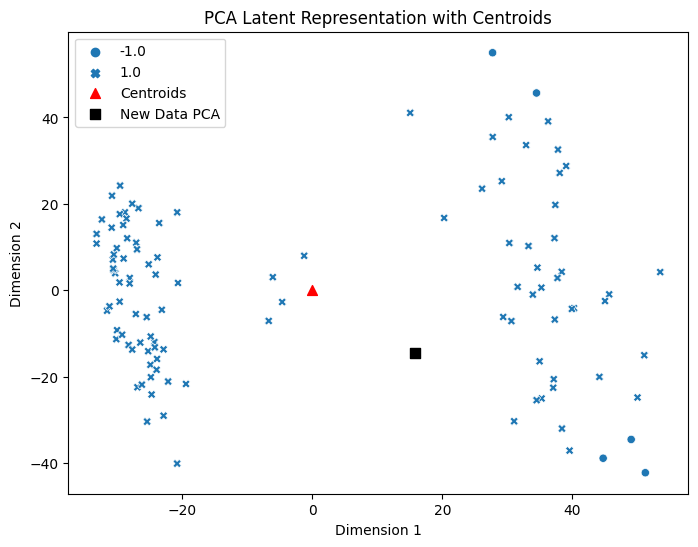

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import pandas as pd
import numpy as np

def plot_vector_distribution(vector_representation, kmeans_labels, scoop_labels, new_data_pca=None):
    pca = PCA(n_components=2, random_state=0)
    pca_result = pca.fit_transform(vector_representation)

    df_pca = pd.DataFrame(pca_result, columns=['Dimension 1', 'Dimension 2'])
    df_pca['Scoop Label'] = scoop_labels

    cluster_palette = sns.color_palette('tab10', n_colors=len(np.unique(kmeans_labels)))
    plt.figure(figsize=(8, 6))
    sns.scatterplot(x='Dimension 1', y='Dimension 2', hue='Scoop Label', style='Scoop Label', data=df_pca, palette=cluster_palette, markers=['o', 'X'], legend='full')
    
    # Menambahkan centroid ke dalam plot
    centroids = []
    for label in np.unique(kmeans_labels):
        centroid = np.mean(pca_result[kmeans_labels == label], axis=0)
        centroids.append(centroid)
    centroids = np.array(centroids)
    plt.scatter(centroids[:, 0], centroids[:, 1], marker='^', c='red', s=50, label='Centroids')
    
    # Menampilkan posisi data PCA baru
    if new_data_pca is not None:
        plt.scatter(new_data_pca[:, 0], new_data_pca[:, 1], marker='s', c='black', s=50, label='New Data PCA')
    
    plt.title('PCA Latent Representation with Centroids')
    plt.xlabel('Dimension 1')
    plt.ylabel('Dimension 2')
    plt.legend()
    plt.show()

    return df_pca


# Menentukan label untuk scoop dan outscoop
scoop_labels = np.ones(len(X_pca))
scoop_labels[jarak_ke_centroid > outscoop_threshold] = -1

df_pca = plot_vector_distribution(X_pca, kmeans_model.labels_, scoop_labels, new_data_pca)